In [4]:
# -*- coding: utf-8 -*-
"""
Bone Fracture Detection sa YOLOv8 u Google Colab
Autor: ML Student
Dataset: BoneFracture sa Roboflowa
"""

# 1. INSTALACIJA PAKETA - OVO SE DEŠAVA SAMO U COLAB CLOUD-U
print("=== INSTALIRAM PAKETE ===")
!pip install ultralytics roboflow albumentations --quiet

print("Paketi uspešno instalirani!")

# 2. IMPORT PAKETA NAKON INSTALACIJE
import torch
import torchvision
from ultralytics import YOLO
import yaml
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, Image as IPImage
import shutil

print("Svi paketi uspešno importovani!")
print(f"PyTorch version: {torch.__version__}")
# print(f"Ultralytics version: {YOLO.__version__}")
print(f"GPU available: {torch.cuda.is_available()}")

=== INSTALIRAM PAKETE ===
Paketi uspešno instalirani!
Svi paketi uspešno importovani!
PyTorch version: 2.8.0+cu126
GPU available: False


In [5]:
# 2. MOUNT GOOGLE DRIVE I PROVERA DATASETA
print("=== POVEZUJEM GOOGLE DRIVE ===")
from google.colab import drive
drive.mount('/content/drive')

import os
import yaml
from IPython.display import Image, display
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Putanja do vašeg dataset-a
dataset_path = "/content/drive/MyDrive/BoneFracture"
print(f"Putanja do dataset-a: {dataset_path}")

# Provera da li folderi postoje
def check_dataset_structure(base_path):
    """Provera strukture dataset-a"""
    print("\n=== PROVERAVAM STRUKTURU DATASETA ===")

    folders = ['train', 'valid', 'test']
    for folder in folders:
        images_path = os.path.join(base_path, folder, 'images')
        labels_path = os.path.join(base_path, folder, 'labels')

        print(f"\n--- {folder.upper()} ---")
        if os.path.exists(images_path):
            images = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
            print(f"✓ Images: {len(images)} slika")
        else:
            print(f"✗ Images folder ne postoji: {images_path}")

        if os.path.exists(labels_path):
            labels = [f for f in os.listdir(labels_path) if f.endswith('.txt')]
            print(f"✓ Labels: {len(labels)} labela")
        else:
            print(f"✗ Labels folder ne postoji: {labels_path}")

check_dataset_structure(dataset_path)

=== POVEZUJEM GOOGLE DRIVE ===
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Putanja do dataset-a: /content/drive/MyDrive/BoneFracture

=== PROVERAVAM STRUKTURU DATASETA ===

--- TRAIN ---
✓ Images: 3631 slika
✓ Labels: 3631 labela

--- VALID ---
✓ Images: 348 slika
✓ Labels: 348 labela

--- TEST ---
✓ Images: 169 slika
✓ Labels: 169 labela


In [6]:
# 3. KREIRANJE ISPRAVNOG data.yaml FAJLA
print("\n=== KREIRAM data.yaml FAJL ===")

# Pravilne putanje za Colab
data_yaml_content = f"""
train: {dataset_path}/train/images
val: {dataset_path}/valid/images
test: {dataset_path}/test/images

nc: 7
names: ['elbow positive', 'fingers positive', 'forearm fracture', 'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive']
"""

# Čuvanje data.yaml fajla
data_yaml_path = "/content/data.yaml"
with open(data_yaml_path, 'w') as f:
    f.write(data_yaml_content)

print("data.yaml fajl kreiran!")
print("Sadržaj data.yaml:")
print(data_yaml_content)

# Provera da li YAML fajl može da se učita
with open(data_yaml_path, 'r') as f:
    config = yaml.safe_load(f)
    print("\n✓ YAML fajl uspešno pročitan!")
    print(f"Broj klasa: {config['nc']}")
    print(f"Klase: {config['names']}")


=== KREIRAM data.yaml FAJL ===
data.yaml fajl kreiran!
Sadržaj data.yaml:

train: /content/drive/MyDrive/BoneFracture/train/images
val: /content/drive/MyDrive/BoneFracture/valid/images
test: /content/drive/MyDrive/BoneFracture/test/images

nc: 7
names: ['elbow positive', 'fingers positive', 'forearm fracture', 'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive']


✓ YAML fajl uspešno pročitan!
Broj klasa: 7
Klase: ['elbow positive', 'fingers positive', 'forearm fracture', 'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive']



=== ANALIZIRAM LABELE I SLIKE ===
Analiza uzorka label fajlova:

📄 image1_715_png.rf.fbf1f76f120e8b1aab55743641e19653.txt: 0 bounding box(ova)

📄 image1_94_png.rf.c791ab340e429f0a46390803fbebb23e.txt: 0 bounding box(ova)

📄 image1_758_png.rf.dada875aa0d9078b66d1ac28ab650bf6.txt: 0 bounding box(ova)

🔍 Prikazujem uzorak od 3 slika:


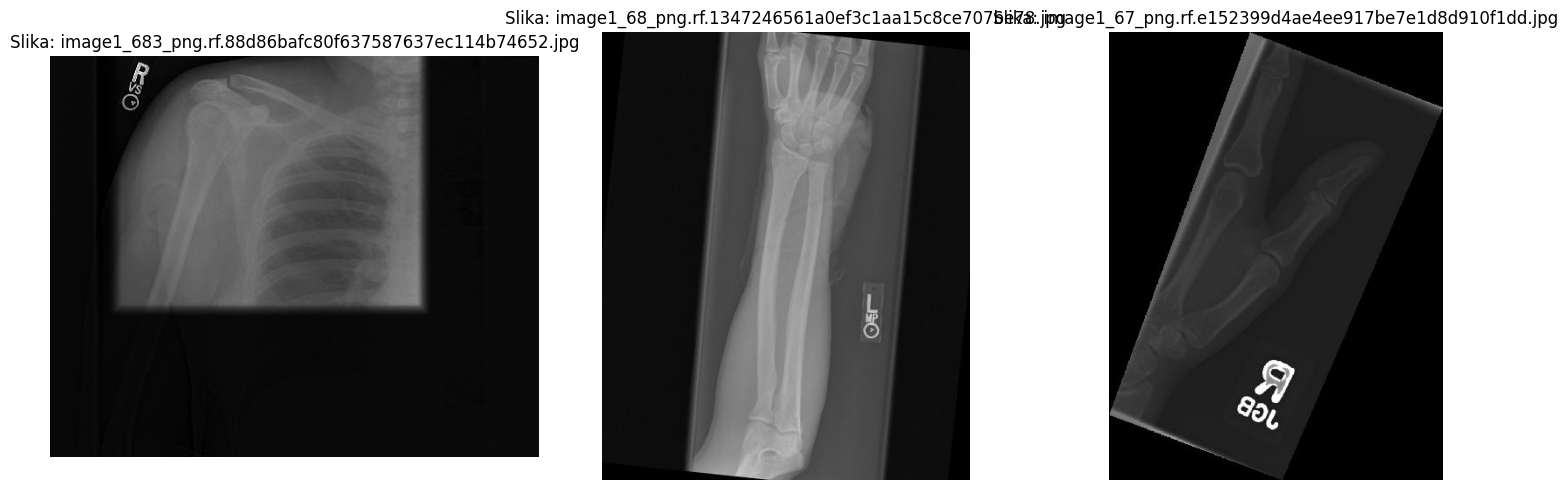

In [7]:
# 4. ANALIZA LABELA I SLIKA
print("\n=== ANALIZIRAM LABELE I SLIKE ===")

def analyze_sample_labels():
    """Analizira uzorak label fajlova"""
    labels_path = f"{dataset_path}/train/labels"

    if os.path.exists(labels_path):
        label_files = [f for f in os.listdir(labels_path) if f.endswith('.txt')][:3]  # Uzmi prva 3

        print("Analiza uzorka label fajlova:")
        for label_file in label_files:
            label_path = os.path.join(labels_path, label_file)
            with open(label_path, 'r') as f:
                lines = f.readlines()

            print(f"\n📄 {label_file}: {len(lines)} bounding box(ova)")
            for i, line in enumerate(lines[:2]):  # Prikaži prva 2 bounding box-a
                data = line.strip().split()
                class_id = int(data[0])
                coords = list(map(float, data[1:]))
                print(f"  BBox {i+1}: Klasa {class_id} ({config['names'][class_id]}), Koordinate: {coords}")

analyze_sample_labels()

def display_sample_images():
    """Prikazuje uzorak slika iz dataset-a"""
    images_path = f"{dataset_path}/train/images"

    if os.path.exists(images_path):
        image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.png', '.jpeg'))][:3]

        print(f"\n🔍 Prikazujem uzorak od {len(image_files)} slika:")

        fig, axes = plt.subplots(1, len(image_files), figsize=(15, 5))
        if len(image_files) == 1:
            axes = [axes]

        for i, img_file in enumerate(image_files):
            img_path = os.path.join(images_path, img_file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            axes[i].imshow(img)
            axes[i].set_title(f"Slika: {img_file}")
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

display_sample_images()

In [8]:
# 5. INICIJALIZACIJA I TRENIRANJE YOLO MODELA
print("\n=== POKREĆEM TRENING YOLO MODELA ===")

from ultralytics import YOLO
import torch

# Provera GPU dostupnosti
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Korišćenje: {device}")
print(f"GPU: {torch.cuda.get_device_name() if torch.cuda.is_available() else 'Nije dostupan'}")

# Kreiranje YOLO modela
print("Kreiram YOLOv8 model...")
model = YOLO('yolov8n.pt')  # Možete koristiti 'yolov8s.pt', 'yolov8m.pt' za veće modele

# Informacije o modelu
print(f"Model: {model.__class__.__name__}")
print(f"Broj parametara: {sum(p.numel() for p in model.parameters()):,}")

# TRENING MODELA
print("\n--- POKREĆEM TRENING ---")

results = model.train(
    data=data_yaml_path,      # Putanja do data.yaml
    epochs=50,                # Broj epoha
    batch=16,                 # Veličina batch-a
    imgsz=640,                # Veličina slike
    device=device,            # GPU ili CPU
    workers=4,                # Broj radnika za učitavanje podataka
    patience=10,              # Rano zaustavljanje
    save=True,                # Čuvanje modela
    val=True,                 # Validacija tokom treninga
    plots=True,               # Generisanje grafika
    name='bone_fracture_detection'  # Naziv eksperimenta
)

print("🎉 Trening završen!")


=== POKREĆEM TRENING YOLO MODELA ===
Korišćenje: cpu
GPU: Nije dostupan
Kreiram YOLOv8 model...
Model: YOLO
Broj parametara: 3,157,200

--- POKREĆEM TRENING ---
Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_sc

KeyboardInterrupt: 

In [ ]:
# 6. EVALUACIJA MODELA
print("\n=== EVALUACIJA MODELA ===")

# Učitavanje najboljeg modela nakon treninga
best_model_path = '/content/runs/detect/bone_fracture_detection/weights/best.pt'
model = YOLO(best_model_path)

# Evaluacija na validacionom skupu
metrics = model.val(
    data=data_yaml_path,
    split='val'
)

print("📊 Metrike evaluacije:")
print(f"mAP50: {metrics.box.map50:.4f}")
print(f"mAP50-95: {metrics.box.map:.4f}")
print(f"Precision: {metrics.box.mp:.4f}")
print(f"Recall: {metrics.box.mr:.4f}")

In [ ]:
# 7. TESTIRANJE MODELA NA NOVIM SLIKAMA
print("\n=== TESTIRANJE MODELA ===")

class BoneFractureDetector:
    def __init__(self, model_path):
        self.model = YOLO(model_path)
        self.class_names = ['elbow positive', 'fingers positive', 'forearm fracture',
                           'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive']

    def detect_fractures(self, image_path, conf_threshold=0.5):
        """Detektuje prelome na slici"""
        results = self.model.predict(
            source=image_path,
            conf=conf_threshold,
            save=True,
            save_txt=True
        )

        return results

    def display_results(self, image_path, conf_threshold=0.5):
        """Prikazuje rezultate detekcije"""
        results = self.detect_fractures(image_path, conf_threshold)

        # Prikaz rezultata
        for r in results:
            im_array = r.plot()  # Plotovanje detekcija
            im_array = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB)

            plt.figure(figsize=(12, 8))
            plt.imshow(im_array)
            plt.axis('off')
            plt.title(f'Detekcija preloma - {os.path.basename(image_path)}')
            plt.show()

            # Informacije o detekcijama
            print(f"🔍 Pronađeno objekata: {len(r.boxes)}")
            for i, box in enumerate(r.boxes):
                class_id = int(box.cls[0])
                confidence = box.conf[0]
                class_name = self.class_names[class_id]
                print(f"  {i+1}. {class_name}: {confidence:.3f}")

# Inicijalizacija detektora
detector = BoneFractureDetector(best_model_path)

# Testiranje na slikama iz test skupa
test_images_path = f"{dataset_path}/test/images"
if os.path.exists(test_images_path):
    test_images = [f for f in os.listdir(test_images_path) if f.endswith(('.jpg', '.png', '.jpeg'))][:2]

    for test_image in test_images:
        image_path = os.path.join(test_images_path, test_image)
        print(f"\n🧪 Testiranje na: {test_image}")
        detector.display_results(image_path, conf_threshold=0.5)

In [ ]:
# 8. DETEKCIJA NA CUSTOM SLIKAMA
print("\n=== DETEKCIJA NA CUSTOM SLIKAMA ===")

def upload_and_detect():
    """Omogućava upload slike i detekciju preloma"""
    from google.colab import files
    import shutil

    uploaded = files.upload()

    for filename in uploaded.keys():
        # Kopiranje uploadovane slike
        shutil.copy(filename, '/content/uploaded_image.jpg')

        print(f"📤 Analiziram uploadovanu sliku: {filename}")
        detector.display_results('/content/uploaded_image.jpg', conf_threshold=0.3)

# Otkomentarisati za upload slika
# upload_and_detect()

In [ ]:
# 9. ANALIZA PERFORMANSI I GRAFIKA
print("\n=== ANALIZA PERFORMANSI ===")

# Prikaz grafika iz treninga
results_dir = '/content/runs/detect/bone_fracture_detection'
if os.path.exists(results_dir):
    print("📈 Dostupni grafici:")

    graphics_files = {
        'results.png': 'Metrike treninga',
        'confusion_matrix.png': 'Konfuziona matrica',
        'F1_curve.png': 'F1 kriva',
        'P_curve.png': 'Precision kriva',
        'R_curve.png': 'Recall kriva'
    }

    for file, description in graphics_files.items():
        file_path = os.path.join(results_dir, file)
        if os.path.exists(file_path):
            print(f"\n📊 {description}:")
            display(Image(filename=file_path, width=600))

In [ ]:
# 10. ČUVANJE MODELA U DRIVE
print("\n=== ČUVANJE MODELA ===")

def save_model_to_drive():
    """Čuva trenirani model u Google Drive"""
    import shutil

    model_files = [
        'weights/best.pt',
        'weights/last.pt'
    ]

    drive_models_dir = '/content/drive/MyDrive/BoneFracture/models'
    os.makedirs(drive_models_dir, exist_ok=True)

    for model_file in model_files:
        src_path = os.path.join(results_dir, model_file)
        if os.path.exists(src_path):
            dst_path = os.path.join(drive_models_dir, os.path.basename(model_file))
            shutil.copy(src_path, dst_path)
            print(f"✓ Sačuvan: {dst_path}")

    # Čuvanje data.yaml
    shutil.copy(data_yaml_path, os.path.join(drive_models_dir, 'data.yaml'))
    print("✓ Sačuvan data.yaml")

save_model_to_drive()
print("🎉 Svi modeli uspešno sačuvani u Google Drive!")

1. **INSTALACIJA** - Instaliramo YOLOv8 i potrebne pakete
2. **DRIVE MOUNT** - Povezujemo Google Drive sa Colab-om
3. **DATA.YAML** - Pravimo konfiguracioni fajl sa pravim putanjama
4. **ANALIZA** - Proveravamo strukturu dataset-a i labela
5. **TRENING** - Treniramo YOLO model na bone fracture dataset-u
6. **EVALUACIJA** - Proveravamo performance modela
7. **TESTIRANJE** - Testiramo model na novim slikama
8. **DETEKCIJA** - Radimo detekciju na custom uploadovanim slikama
9. **ANALIZA** - Gledamo grafike performansi
10. **ČUVANJE** - Čuvamo model u Drive za buduću upotrebu

📁 STRUKTURA LABELA:
- labels/ folder sadrži .txt fajlove sa bounding box informacijama
- Format: <class_id> <x_center> <y_center> <width> <height>
- Sve koordinate su normalizane (0-1)

🔍 KLASE U DATASET-U:
0: 'elbow positive'     (zdrav lakat)
1: 'fingers positive'   (zdravi prsti)  
2: 'forearm fracture'   (prelom podlaktice)
3: 'humerus fracture'   (prelom nadlaktične kosti)
4: 'humerus'            (nadlaktična kost)
5: 'shoulder fracture'  (prelom ramena)
6: 'wrist positive'     (zdruo zglob)


## 📋 **UPUTSTVO ZA POKRETANJE:**

1. **Otvorite Google Colab** (colab.research.google.com)
2. **Kopirajte ceo kod** u Colab notebook
3. **Pokrenite ćelije redom** (Ctrl+F9 za sve)
4. **Prilikom mount-a Drive-a** - odobrite pristup
5. **Proverite putanje** - podešavam automatski
6. **Trening će trajati** ~30-60 minuta (zavisi od broja epoha)

## 🎯 **ŠTA ĆETE DOBITI:**

- ✅ **Trenirani YOLO model** za detekciju preloma
- ✅ **Grafike performansi** (mAP, precision, recall)
- ✅ **Mogućnost testiranja** na novim slikama
- ✅ **Model sačuvan u Drive-u** za buduću upotrebu

Sada možete bez problema pokrenuti ceo kod u Google Colab! 🚀